In [1]:
suppressPackageStartupMessages({
  suppressMessages({
    suppressWarnings({
        library(dplyr)
        library(Seurat)
        library(readr)
        library(ggplot2)
        library("org.Mm.eg.db")
        # convert symbols to ensembl ids
        convert_to_ensembl <- function(symbols) {
            ensembl_ids <- mapIds(org.Mm.eg.db, keys = symbols, keytype = "SYMBOL", column = "ENSEMBL")
            return(ensembl_ids)
        }
        convert_to_symbol <- function(ensembl_ids) {
            symbols <- mapIds(org.Mm.eg.db, keys = ensembl_ids, keytype = "ENSEMBL", column = "SYMBOL")
            return(symbols)
        }
        library(purrr)
    })
  })
})

In [2]:
batch_to_label <- c(exp05 = "batch1", exp06 = "batch2", exp07 = "batch3", exp08 = "batch4", exp09 = "batch5", exp10 = "batch6", exp11 = "batch7", `exp12-13`="batch8", exp14 = "batch9")
# scp updepla_tf_seq_rwd@fts.epfl.ch:sv_fts-updepla/tf_seq/Wangjie/4-Seurat_objects/C3H10_10X_all_exps_D0regressed10pc_50pc_integrated_dosealigned.rds ./
# scp updepla_tf_seq_rwd@fts.epfl.ch:sv_fts-updepla/tf_seq/Wangjie/4-Seurat_objects/C3H10_10X_all_exps_merged_genefiltered_50pc_integrated.rds ./
# scp updepla_tf_seq_rwd@fts.epfl.ch:sv_fts-updepla/tf_seq/Wangjie/4-Seurat_objects/Functional_metadata_C3H10_10X_all_exps_merged_genefiltered_50pc_integrated_functional.rds ./Functional_metadata_C3H10_10X_all_exps_merged_genefiltered_50pc_integrated_functional.rds
# scp updepla_tf_seq_rwd@fts.epfl.ch:sv_fts-updepla/tf_seq/Wangjie/4-Seurat_objects/Metadata_dose_aligned.rds ./Metadata_dose_aligned.rds
# scp updepla_tf_seq_rwd@fts.epfl.ch:sv_fts-updepla/tf_seq/Wangjie/4-Seurat_objects/df_allG1Cells_PhaseCorrected_allTFs_D0regressed10pc_50pc_integrated.rds ./df_allG1Cells_PhaseCorrected_allTFs_D0regressed10pc_50pc_integrated.rds

In [3]:
plots_folder <- path.expand("plots")
if(!dir.exists(plots_folder)) {
    dir.create(plots_folder, recursive = TRUE)
}

In [4]:
data_folder <- path.expand("../../data")

In [11]:
seu <- read_rds(file.path(data_folder, "C3H10_10X_all_exps_D0regressed10pc_50pc_integrated_dosealigned.rds"))
seu2 <- read_rds(file.path(data_folder, "C3H10_10X_all_exps_merged_genefiltered_50pc_integrated.rds"))

In [12]:
metadata_dose_aligned <- read_rds(file.path(data_folder, "Metadata_dose_aligned.rds"))
functional_metadata <- read_rds(file.path(data_folder, "Functional_metadata_C3H10_10X_all_exps_merged_genefiltered_50pc_integrated_functional.rds"))

In [13]:
seu2$Dose <- seu$Log_Vector_UMI
seu2$Dose_aligned <- metadata_dose_aligned
seu2$functional_cells <- functional_metadata

In [14]:
setNames(seu2$functional_cells, colnames(seu2))[colnames(seu)] -> seu$functional_cells

In [15]:
# !scp updepla_tf_seq_rwd@fts.epfl.ch:sv_fts-updepla/tf_seq/Wangjie/6-tmp/TF_categories_on_potency_capacity_dosealigned.csv ./
# 
functionality <- read_csv(file.path(data_folder, "TF_categories_on_potency_capacity_dosealigned.csv"))
colnames(functionality)[1] <- "TF_row"

# strip whitespace
functionality$TF <- map_chr(functionality$TF, stringr::str_trim)
functionality$TF_row <- map_chr(functionality$TF_row, stringr::str_trim)

New names:
• `` -> `...1`
Rows: 232 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): ...1, TF, category
dbl (8): Asym, xmid, scal, Dose.max, Dose.min, startpoint, endpoint, predict...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Scaling

In [16]:
seu2$batch_overall <- unname(c(exp05 = "batch1", exp06 = "batch1", exp07 = "batch2", exp08 = "batch2", exp09 = "batch3", exp10 = "batch4", exp11 = "batch4", `exp12-13`="batch5", exp14 = "batch6")[seu2$batch])

In [17]:
max_doses <- seu2@meta.data |> arrange(-Dose) |> group_by(batch_overall, TF) |> summarize(Dose = quantile(Dose, 0.9)) |> ungroup() |> dplyr::select(batch_overall, TF, Dose) |> filter(!(TF %in% c("D0", "D0_confluent", "Adipo_ref", "Irf3", "Bhlhe40", "Vdr")))

# Only take TFs with high enough absolute dose
max_doses_selected <- max_doses |> filter(Dose > 3.5)

`summarise()` has grouped output by 'batch_overall'. You can override using the
`.groups` argument.


In [18]:
# Only take TFs in batch2 and batch 6
tfs_oi <- max_doses_selected |> dplyr::filter(batch_overall %in% c("batch2", "batch6")) |> group_by(TF, batch_overall) |> summarise(n = n()) |> group_by(TF) |> summarise(n = n()) |> arrange(desc(n)) |> filter(n >= 2)  |> pull(TF)

`summarise()` has grouped output by 'TF'. You can override using the `.groups`
argument.


In [19]:
# tfs_oi <- c("Pparg", "Mycn")
# tfs_oi <- c("Klf4")

In [53]:
select_tf_dataset <- function(seu, tf, batches = NULL) {
    filtered_tf <- seu@meta.data |> filter((TF == !!tf) & (Phase == "G1"))
    if (is.null(batches)) {
        batches_oi <- unique(filtered_tf$batch_overall)
    } else {
        batches_oi <- batches
    }
    filtered_control <- seu@meta.data |> filter((TF %in% c("D0", "D0_confluent")) & (Phase == "G1") & (batch_overall %in% batches_oi))
    filtered_tf <- filtered_tf |> filter(batch_overall %in% batches_oi)
    filtered <- rbind(filtered_control, filtered_tf)
    seu <- seu |> subset(cells = rownames(filtered))
    return(seu)
}


select_tf_datasets <- function(seu, tf, batches = NULL) {
    filtered_tf <- seu@meta.data |> filter((TF == !!tf) & (Phase == "G1"))
    if (is.null(batches)) {
        batches_oi <- unique(filtered_tf$batch_overall)
    } else {
        batches_oi <- batches
    }
    filtered_control <- seu@meta.data |> filter((TF %in% c("D0", "D0_confluent")) & (Phase == "G1") & (batch_overall %in% batches_oi))
    filtered_tf <- filtered_tf |> filter(batch_overall %in% batches_oi)
    filtered <- rbind(filtered_control, filtered_tf)

    datasets <- list()
    for (batch in batches_oi) {
        filtered_oi <- filtered |> filter(batch_overall == !!batch)
        dataset <- seu |> subset(cells = rownames(filtered_oi))
        datasets[[batch]] <- dataset
    }
    return(datasets)
}

select_tf_datasets_batch <- function(seu, tf, batches = NULL) {
    filtered_tf <- seu@meta.data |> filter((TF == !!tf) & (Phase == "G1"))
    if (is.null(batches)) {
        batches_oi <- unique(filtered_tf$batch)
    } else {
        batches_oi <- batches
    }
    filtered_control <- seu@meta.data |> filter((TF %in% c("D0", "D0_confluent")) & (Phase == "G1") & (batch %in% batches_oi))
    filtered_tf <- filtered_tf |> filter(batch %in% batches_oi)
    filtered <- rbind(filtered_control, filtered_tf)

    datasets <- list()
    for (batch in batches_oi) {
        filtered_oi <- filtered |> filter(batch == !!batch)
        dataset <- seu |> subset(cells = rownames(filtered_oi))
        datasets[[batch]] <- dataset
    }
    return(datasets)
}

In [24]:
mappings_tfs <- list()

for (tf in tfs_oi) {
    print(tf)

    # filter on batches with high dose
    batches <- max_doses_selected |> filter(TF == tf) |> pull(batch_overall)
    seu_tf <- select_tf_dataset(seu, tf, batches = batches)
    seus_tf <- select_tf_datasets(seu, tf, batches = batches)

    DefaultAssay(seu_tf) <- "corrected"

    # take the union of 1000 variable genes
    features <- c()
    for (batch in batches) {
        stds <- apply(seu_tf[,seu_tf$batch_overall == batch]@assays$corrected@data, 1, sd) 
        features <- c(features, rownames(seu_tf@assays$corrected@data)[order(-stds)][1:1000])
    }
    VariableFeatures(seu_tf) <- unique(features)
    # VariableFeatures(seu_tf) <- rownames(seu_tf)

    layer <- "corrected"
    spline_values_batches <- map(seus_tf, function(seu) {
        Y <- t(seu@assays[[layer]]@data[VariableFeatures(seu_tf), ])
        x <- seu$Dose

        # xmax <- max(x)
        xmax <- quantile(x[x>0], 0.9)

        knots <- c(seq(0, xmax, 0.5), xmax)
        
        x_desired <- c(seq(0., xmax,by = 0.025), xmax)
        # x_desired <- c(seq(0., xmax,length.out=100), xmax)
        
        spline_values <- apply(Y, 2, function(y) {
            if (sum(y > 0) < 3) {
                return(rep(0, length(x_desired)))
            }
            spline <- smooth.spline(x, y, all.knots = knots, tol = 0.5)
            predict(spline, x_desired)$y
        })

        return(list(y = spline_values, x = x_desired))
    })

    # combinations = data.frame(t(combn(names(spline_values_batches), 2)))
    combinations = expand.grid(names(spline_values_batches), names(spline_values_batches))
    colnames(combinations) <- c("batch1", "batch2")
    combinations$oi <- map2_lgl(combinations$batch1, combinations$batch2, function(batch1, batch2) {
        # check whether batch1 is earlier than batch 2 in the levels
        return (which(names(spline_values_batches) == batch1) > which(names(spline_values_batches) == batch2))
    })
    combinations <- combinations |> dplyr::filter(oi)

    mapping <- function(scaling, x1, x2, y1, y2){
        x2_scaled <- x2 * scaling
        mapping <- map_int(x2_scaled, ~which.min(abs(x1 - .x)))
        dist1 <- sum(rowMeans((y1[mapping, ] - y2[, ])**2))

        x1_scaled <- x1 / scaling
        mapping <- map_int(x1_scaled, ~which.min(abs(x2 - .x)))
        dist2 <- sum(rowMeans((y2[mapping, ] - y1[, ])**2))

        return(dist1 + dist2)
    }

    combinations_oi <- combinations |> dplyr::filter(oi)

    mappings <- map2_dfr(combinations_oi$batch1, combinations_oi$batch2, function(batch1, batch2) {
        y1 <- spline_values_batches[[batch1]]$y
        y2 <- spline_values_batches[[batch2]]$y

        # center at Dose 0
        y1 <- sweep(y1, 2, y1[1, ], "-")
        y2 <- sweep(y2, 2, y2[1, ], "-")

        x1 <- spline_values_batches[[batch1]]$x
        x2 <- spline_values_batches[[batch2]]$x

        scalers <- 2**(seq(-2., 2., length.out = 100))
        distances <- purrr::map_dbl(scalers, mapping, x1 = x1, x2 = x2, y1 = y1, y2 = y2)
        plotdata <- tibble(scaling = scalers, distance = distances, batch1 = batch1, batch2 = batch2)
    })

    mappings_tfs[[tf]] <- mappings
}

[1] "Egr1"
[1] "Esr2"
[1] "Etv1"
[1] "Fos"
[1] "Grhl2"
[1] "Meis2"
[1] "Pou5f1"
[1] "Zfp24"
[1] "Zfp692"


In [25]:
mappings <- map2_dfr(mappings_tfs, names(mappings_tfs), function(df, name) {mutate(df, tf = name)})

In [26]:
mappings$pair <- paste(mappings$tf, mappings$batch1, mappings$batch2)

mappings_oi <- mappings
# mappings_oi <- mappings |> dplyr::filter(batch1 == "batch4" & batch2 == "batch3")
# mappings_oi <- mappings |> dplyr::filter(batch1 == "batch2" & batch2 == "batch1")
# mappings_oi <- mappings |> dplyr::filter(batch1 == "batch3" & batch2 == "batch1")
# mappings_oi <- mappings |> dplyr::filter(batch1 == "batch6" & batch2 == "batch2")
# mappings_oi <- mappings |> dplyr::filter(batch1 == "batch6" & batch2 == "batch1")
mappings_oi <- mappings |> dplyr::filter(batch1 == "batch6" & batch2 == "batch2")
optimal_mappings <- mappings_oi |> arrange(distance) |> group_by(tf, batch1, batch2) |> dplyr::slice(1)
final_mappings <- mappings_oi |> group_by(tf, batch1, batch2) |> dplyr::slice(which.max(scaling))
optimal_mapping <- exp(mean(log(optimal_mappings$scaling)))
mappings_oi$label <- toupper(mappings_oi$tf)
optimal_mappings$label <- toupper(optimal_mappings$tf)
final_mappings$label <- toupper(final_mappings$tf)

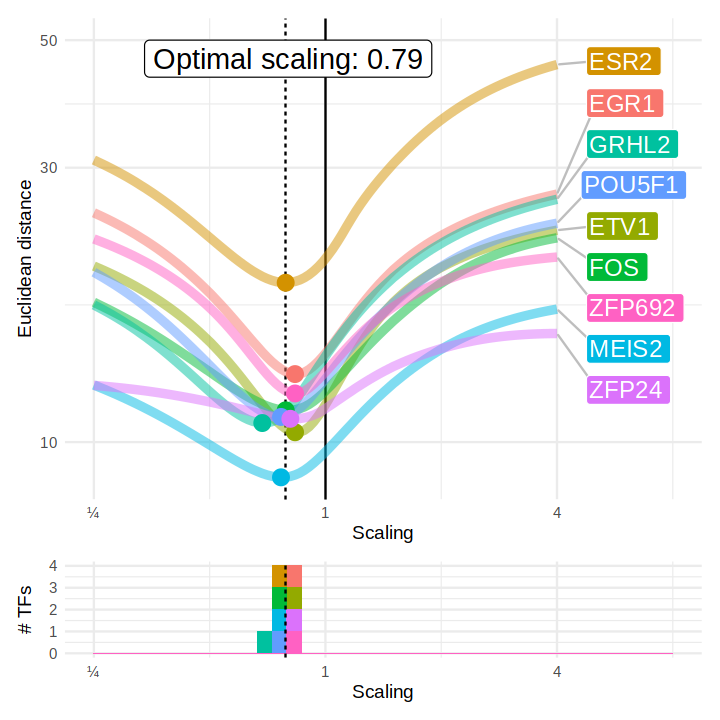

In [28]:
options(repr.plot.width=6, repr.plot.height=6)
plot1 <- ggplot(mappings_oi) + 
geom_vline(xintercept = optimal_mapping, linetype = "dashed") +
geom_vline(xintercept = 1) +
geom_line(aes(x = scaling, y = distance, color = pair), linewidth = 2, alpha = 0.5) + 
scale_x_log10(name = "Scaling", breaks = c(1/4, 1, 4), labels = c("¼", 1, 4), limits = c(1/4, 8)) + 
scale_y_log10() +
theme_minimal() + 
geom_point(data = optimal_mappings, aes(x = scaling, y = distance, color = pair), size = 4) +
ggrepel::geom_label_repel(data = final_mappings, aes(label = label, x = scaling, y = distance, fill = pair), color = "white", segment.color = "grey", segment.size = 0.5, nudge_y = 0, nudge_x = 0.1, lineheight = 1.2, size = 5, direction = "y", hjust = 0.) +
geom_label(data = tibble(x = 0.8, y = 50, label = paste0("Optimal scaling: ", round(optimal_mapping, 2))), aes(x = x, y = y, label = label), hjust = 0.5, vjust = 1, size = 6) +
theme(legend.position = "none") + ylab("Euclidean distance")

plot2 <- ggplot(optimal_mappings) + geom_histogram(aes(x = scaling, fill = label), breaks = exp(seq(log(min(mappings$scaling)), log(8), length.out = 40))) + scale_x_log10(name = "Scaling", breaks = c(1/4, 1, 4), labels = c("¼", 1, 4), limits = c(1/4, 8)) + theme_minimal()  +
geom_vline(xintercept = optimal_mapping, linetype = "dashed") +
theme(legend.position = "none") + ylab("# TFs")

plot <- patchwork::wrap_plots(plot1, plot2, ncol = 1, heights = c(5, 1))
ggsave(file.path(plots_folder, "scaling.pdf"), plot, width = 6, height = 7)
plot

In [29]:
optimal_mappings

scaling,distance,batch1,batch2,tf,pair,label
<dbl>,<dbl>,<fct>,<fct>,<chr>,<chr>,<chr>
0.8335691,13.129609,batch6,batch2,Egr1,Egr1 batch6 batch2,EGR1
0.7881629,18.927376,batch6,batch2,Esr2,Esr2 batch6 batch2,ESR2
0.8335691,10.401548,batch6,batch2,Etv1,Etv1 batch6 batch2,ETV1
0.7881629,11.356412,batch6,batch2,Fos,Fos batch6 batch2,FOS
0.6851755,10.792782,batch6,batch2,Grhl2,Grhl2 batch6 batch2,GRHL2
0.7663958,8.684366,batch6,batch2,Meis2,Meis2 batch6 batch2,MEIS2
0.7663958,11.059139,batch6,batch2,Pou5f1,Pou5f1 batch6 batch2,POU5F1
0.8105481,10.977397,batch6,batch2,Zfp24,Zfp24 batch6 batch2,ZFP24
0.8335691,12.149629,batch6,batch2,Zfp692,Zfp692 batch6 batch2,ZFP692


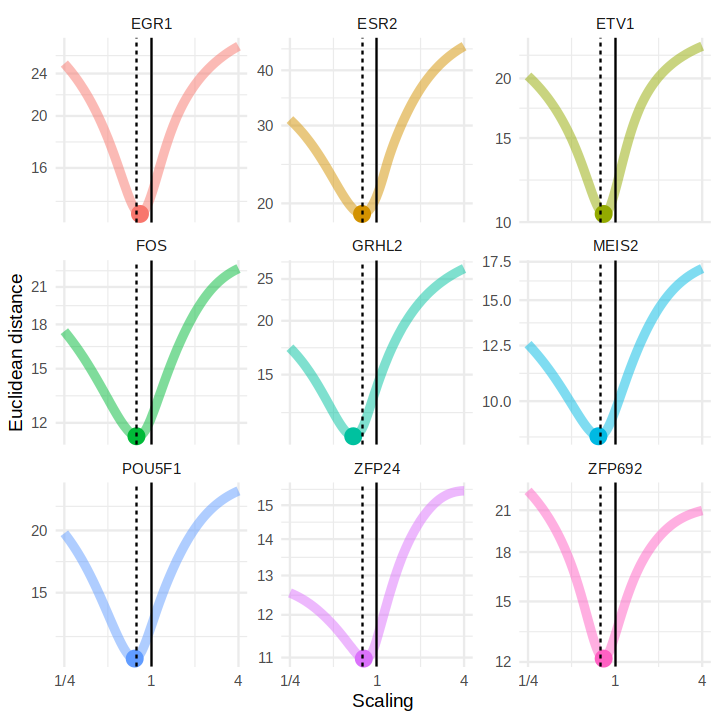

In [30]:
plot <- mappings_oi |> 
    ggplot(aes(x = scaling, y = distance, color = label)) + 
    geom_line(size=2, alpha = 0.5) + 
    # geom_vline(aes(xintercept = scaling, color = tf), data = optimal_mappings, linetype = "dashed") +
    geom_point(aes(x = scaling, y = distance, color = label), data = optimal_mappings, size = 4) +
    facet_wrap(~label,scales = "free_y") + 
    scale_y_log10() + 
    scale_x_log10(breaks = c(1/4, 1, 4), labels = c("1/4", "1", "4")) +
    theme_minimal() + 
    geom_vline(xintercept = optimal_mapping, linetype = "dashed") +
    geom_vline(xintercept = 1) +
    theme(legend.position = "None") +
    xlab("Scaling") + ylab("Euclidean distance")
ggsave(file.path(plots_folder, "scaling_individual.pdf"), plot, width = 6, height = 7)
plot

### Look at genes before and after scaling

In [32]:
batch_colors <- c(exp05 = "#8da0ca", exp06 = "#e38cbb", exp07 = "#a6d056", exp08 = "#fed82f", exp09 = "#e4c494", exp10 = "#66c2a5", exp11 = "#fc8d62", `exp12-13` = "#ffcccc", exp14 = "#cc9999")

In [94]:
TF_oi <- "Fos"
# TF_oi <- "Esr2"
# TF_oi <- "Egr1"
# TF_oi <- "Meis2"
# TF_oi <- "Pou5f1"
# TF_oi <- "Grhl2"

seu_tf <- select_tf_dataset(seu2, TF_oi) # use original data for differential genes
seu_tf <- SetIdent(seu_tf, value = "TF")
markers <- FindMarkers(seu_tf, ident.1 = "D0_confluent", ident.2 = TF_oi)
# markers <- markers[!(rownames(markers) %in% c("ENSMUSG00000086474", "ENSMUSG00000111467", "ENSMUSG00000097652", "ENSMUSG00000093507", "ENSMUSG00000085604", "ENSMUSG00000001119", "ENSMUSG00000020241")), ]

In [95]:
seu_tf <- select_tf_dataset(seu, TF_oi, batches = c("batch2", "batch6")) # use original data for differential genes
seus_tf <- select_tf_datasets_batch(seu, TF_oi, batches = c("exp07", "exp14")) # use corrected data for plotting

In [96]:
layer <- "corrected_integrated"
gene_ids <- VariableFeatures(seu_tf)

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

Warning message:
“Could not find ENSMUSG00000069662 in the default search locations, found in ‘corrected’ assay instead”
'select()' returned 1:1 mapping between keys and columns

Warning m

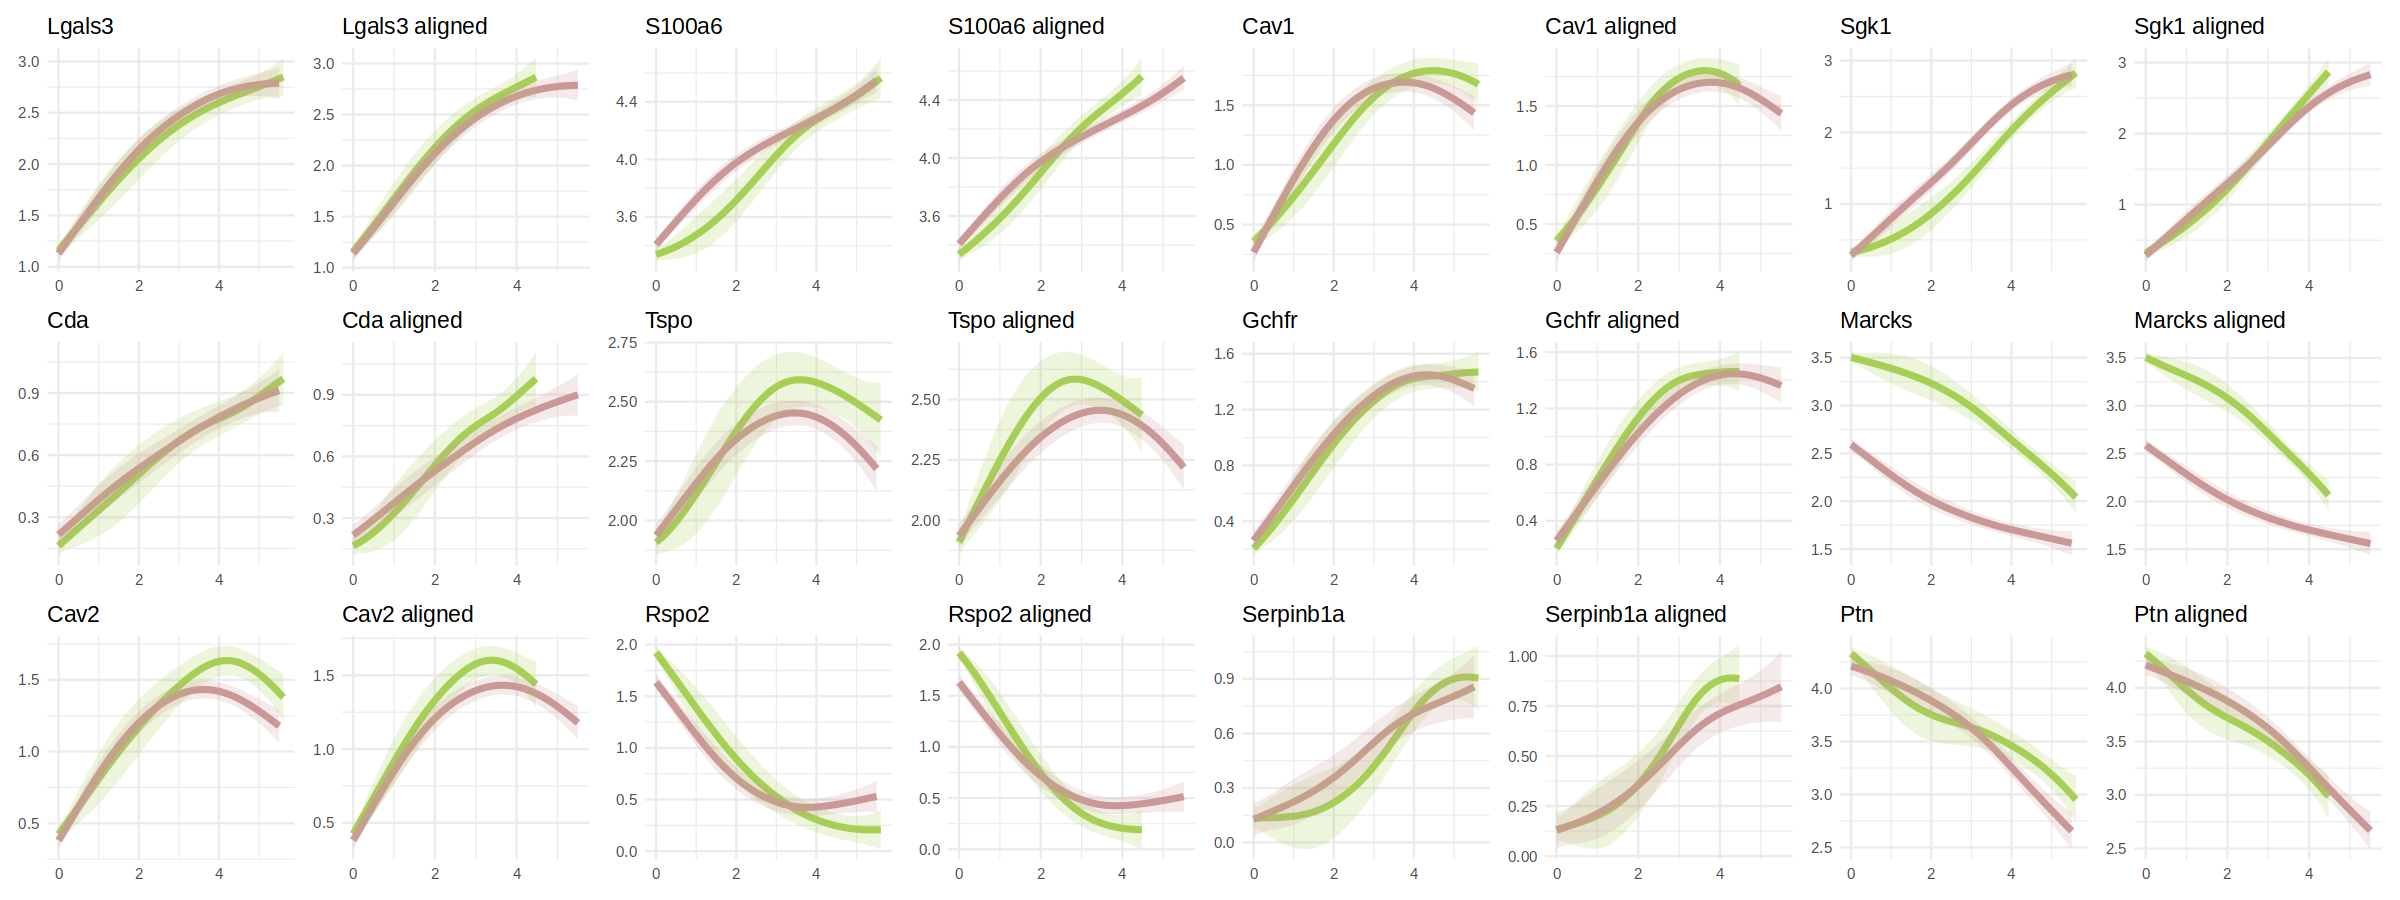

In [97]:
plots <- list()
for (gene in rownames(markers)[1:12]) {
    gene_ix <- which(gene_ids == gene)
 
    for (aligned in c(F, T)) {
        plotdata_dots <- seu_tf@meta.data
        plotdata_dots$expression <- Seurat::FetchData(seu_tf, vars = gene, assay = layer)[[1]]

        plotadata <- map_dfr(names(seus_tf), function(batch) {
            data <- plotdata_dots |> dplyr::filter(batch == !!batch)
            if (nrow(data) == 0) {
                return(tibble())
            }
            if (aligned) {
                x <- data$Dose_aligned
                x_noisy <- data$Dose_aligned + rnorm(nrow(data), sd = 0.1)
                x_pred <- seq(0, quantile(x[x>0], 0.95), length.out = 100)
            } else {
                x <- data$Dose
                x_noisy <- data$Dose + rnorm(nrow(data), sd = 0.1)
                x_pred <- seq(0, quantile(x[x>0], 0.95), length.out = 100)
            }
            y <- data$expression


            # Fit a GAM with a smoothing spline, just like smooth.spline
            gam_model <- mgcv::gam(y ~ s(x_noisy, sp = 1), method = 'REML')

            # Make predictions
            y_pred <- predict(gam_model, newdata = data.frame(x_noisy = x_pred), type = 'response', se.fit = TRUE)

            # Extract predicted values and standard errors
            fit <- y_pred$fit
            se <- y_pred$se.fit

            # Calculate confidence intervals
            data.frame(x = x_pred, y = fit, se = se, batch = batch)
        })

        tryCatch(
        symbol <- convert_to_symbol(gene),
        error = function(e) {
            symbol <- gene
        }
        )

        options(repr.plot.width=3, repr.plot.height=3)
        plot <- ggplot(plotadata) + 
        geom_line(aes(x = x, y = y, color = batch), linewidth = 1.5) + 
        geom_ribbon(aes(x = x, ymin = y - se*2, ymax = y + se*2, fill = batch), alpha = 0.2) +
        # geom_point(aes(x = Dose, y = expression, color = batch), alpha = 0.1, data = plotdata_dots, size= 0.1) +
        theme_minimal() + 
        theme(legend.position = "None") + xlab("Dose") + ylab("Expression") + ggtitle(ifelse(aligned, paste0(symbol, " aligned"), symbol)) +
        scale_color_manual(values = batch_colors) + scale_fill_manual(values = batch_colors) +
        scale_y_continuous(name = NULL) +
        scale_x_continuous(name = NULL)

        plots <- c(plots, list(plot))
    }
}
ncol <- min(8, length(plots))
nrow <- ceiling(length(plots) / ncol)
plot <- patchwork::wrap_plots(plots, ncol = ncol, nrow,)
options(repr.plot.width=ncol * 2.5, repr.plot.height=nrow * 2.5)
plot

ggsave(file.path(plots_folder, paste0("dose_response_", TF_oi, "_aligned.pdf")), plot, width = ncol * 2.5, height = nrow * 2.5)

In [98]:
get_ensembl_id <- function(symbol) {
    ensembl <- biomaRt::useMart("ensembl", dataset = "mmusculus_gene_ensembl")
    genes <- biomaRt::getBM(attributes = c("ensembl_gene_id", "external_gene_name"), filters = "external_gene_name", values = symbol, mart = ensembl)
    return(genes$ensembl_gene_id)
}

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns



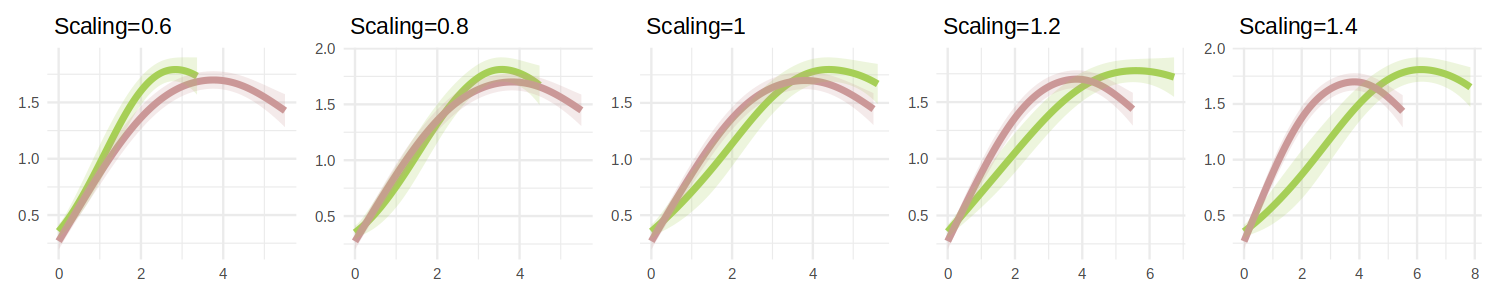

In [99]:
plots <- list()
for (gene in convert_to_ensembl("Cav1")) {
    gene_ix <- which(gene_ids == gene)

    for (scaling in c(0.6, 0.8, 1, 1.2, 1.4)) {
        plotdata_dots <- seu_tf@meta.data
        plotdata_dots$expression <- Seurat::FetchData(seu_tf, vars = gene, assay = layer)[[1]]

        plotdata <- map_dfr(names(seus_tf), function(batch) {
            data <- plotdata_dots |> dplyr::filter(batch == !!batch)
            if (nrow(data) == 0) {
                return(tibble())
            }
            data$Dose <- ifelse(data$batch == "exp07", data$Dose * scaling, data$Dose)
            x <- data$Dose
            x_noisy <- data$Dose + rnorm(nrow(data), sd = 0.1)
            x_pred <- seq(0, quantile(x[x>0], 0.95), length.out = 100)
            y <- data$expression

            # Fit a GAM with a smoothing spline, just like smooth.spline
            gam_model <- mgcv::gam(y ~ s(x_noisy, sp = 1), method = 'REML')

            # Make predictions
            y_pred <- predict(gam_model, newdata = data.frame(x_noisy = x_pred), type = 'response', se.fit = TRUE)

            # Extract predicted values and standard errors
            fit <- y_pred$fit
            se <- y_pred$se.fit

            # Calculate confidence intervals
            data.frame(x = x_pred, y = fit, se = se, batch = batch)
        })

        tryCatch(
        symbol <- convert_to_symbol(gene),
        error = function(e) {
            symbol <- gene
        }
        )

        options(repr.plot.width=3, repr.plot.height=3)
        plot <- ggplot(plotdata) + 
        geom_line(aes(x = x, y = y, color = batch), linewidth = 1.5) + 
        geom_ribbon(aes(x = x, ymin = y - se*2, ymax = y + se*2, fill = batch), alpha = 0.2) +
        # geom_point(aes(x = Dose, y = expression, color = batch), alpha = 0.1, data = plotdata_dots, size= 0.1) +
        theme_minimal() + 
        theme(legend.position = "None") + xlab("Dose") + ylab("Expression") + ggtitle(paste0(" Scaling=", scaling)) +
        scale_color_manual(values = batch_colors) + scale_fill_manual(values = batch_colors) +
        scale_y_continuous(name = NULL) +
        scale_x_continuous(name = NULL)

        plots <- c(plots, list(plot))
    }
}
ncol <- min(8, length(plots))
nrow <- ceiling(length(plots) / ncol)
plot <- patchwork::wrap_plots(plots, ncol = ncol, nrow,)
options(repr.plot.width=ncol * 2.5, repr.plot.height=nrow * 2.5)
plot

ggsave(file.path(plots_folder, paste0("dose_response_", TF_oi, "_aligned_example.pdf")), plot, width = ncol * 2.5, height = nrow * 2.5)
ggsave(file.path(paste0("dose_alignment.png")), plot, width = ncol * 2.5, height = nrow * 2.5)